In [1]:
import itertools
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
gene_list=['K11707','K11708','K11709','K11710','K12436','K09802','K07671','K03289','K03283','K03006','K02663']
Disease_list=['Arthritis_High','Arthritis_Moderate','ColorectalCancer_AdvancedAdenoma','ColorectalCancer_Carcinoma','CrohnsDisease','LiverCirrhosis','Obesity','Type2Diabetes','UlcerativeColitis']
control_list=['Arthritis_None','Arthritis_None','ColorectalCancer_Controls','ColorectalCancer_Controls','CrohnsDisease_None','LiverCirrhosis_None','Obesity_None','Type2Diabetes_None','UlcerativeColitis_None']
dir1 = 'gene abundance (disease)/'
dir2 ='optimum parameter in randomforest/'   
random_stateT =[1,3,5,7,9]
n_estimatorsT = range(1, 201)

# get the parameter of random forest
for i in range(len(Disease_list)):
    df0=pd.read_csv(dir1+Disease_list[i]+'_Gene_abundance',index_col=0,sep='\t')
    df1=pd.read_csv(dir1+control_list[i]+'_Gene_abundance',index_col=0,sep='\t')

    data = pd.concat([
        df0[gene_list].assign(index=1),
        df1[gene_list].assign(index=0)
    ])
    y = data['index'].values
    X = data.drop(columns='index').values

    result_matrix_test = np.zeros((len(random_stateT), len(n_estimatorsT)))
    result_matrix_train = np.zeros((len(random_stateT), len(n_estimatorsT)))
    for j in np.arange(len(random_stateT)):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=random_stateT[j],stratify=y)
        for k in np.arange(len(n_estimatorsT)):
            clf = RandomForestClassifier(n_estimators=n_estimatorsT[k], random_state=random_stateT[j])
            clf.fit(X_train, y_train)
            y_test_proba = clf.predict_proba(X_test)[:, 1]
            y_train_proba = clf.predict_proba(X_train)[:, 1]
            fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
            fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
            roc_auc_test = auc(fpr_test, tpr_test)
            roc_auc_train = auc(fpr_train, tpr_train)
            result_matrix_test[j, k] = roc_auc_test
            result_matrix_train[j, k] = roc_auc_train
    random_stateT_name = [str(a) + str(b) for a, b in zip(['random_stateT']*len(random_stateT), random_stateT)]
    n_estimatorsT_name = [str(a) + str(b) for a, b in zip(['n_estimatorsT']*len(n_estimatorsT), n_estimatorsT)]
    result_matrix__train = pd.DataFrame(result_matrix_train, columns=n_estimatorsT_name, index=random_stateT_name).T
    result_matrix__train.to_csv(dir2+'(Train) optimum parameter of '+Disease_list[i]+' in random forest(11_genes).csv', index=True)
    result_matrix_test = pd.DataFrame(result_matrix_test, columns=n_estimatorsT_name, index=random_stateT_name).T
    result_matrix_test.to_csv(dir2+'(Test) optimum parameter of '+Disease_list[i]+' in random forest(11_genes).csv', index=True)


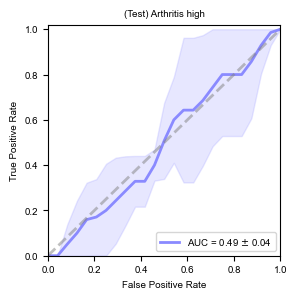

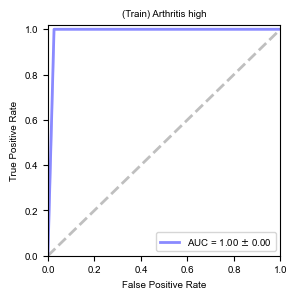

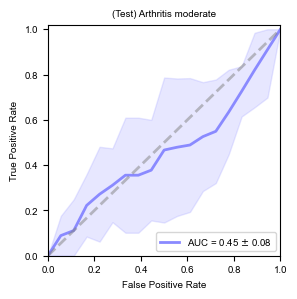

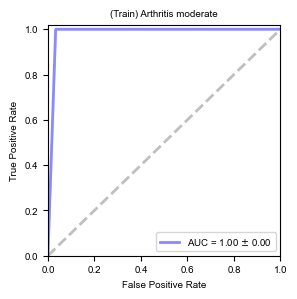

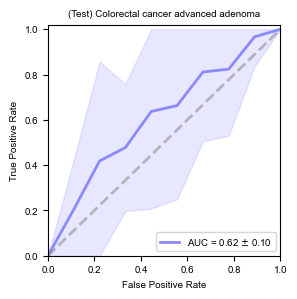

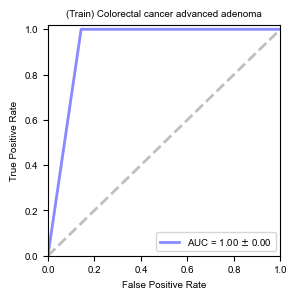

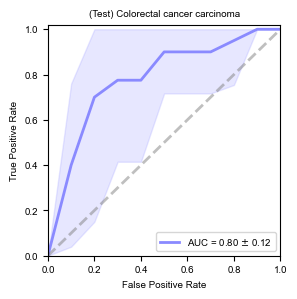

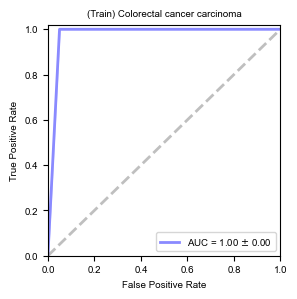

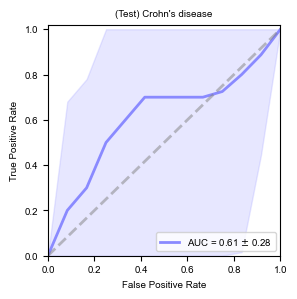

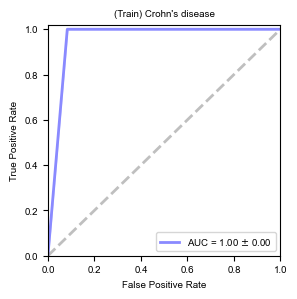

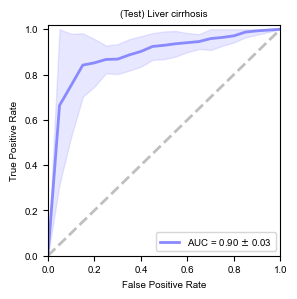

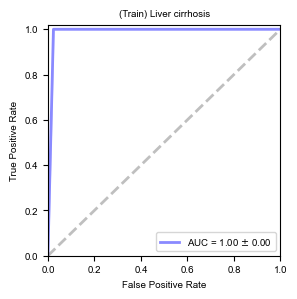

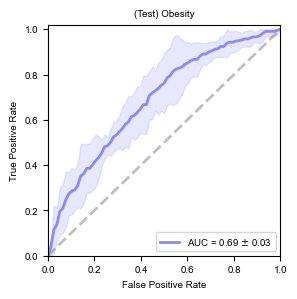

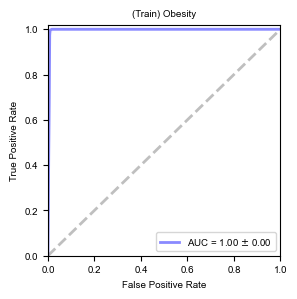

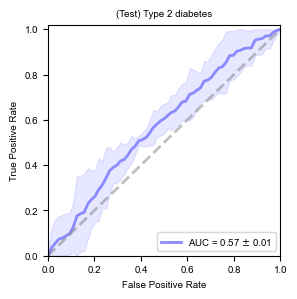

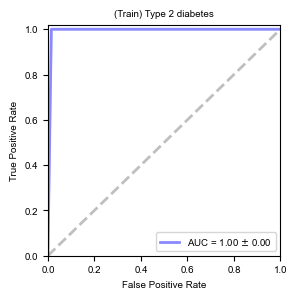

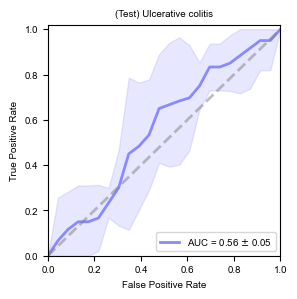

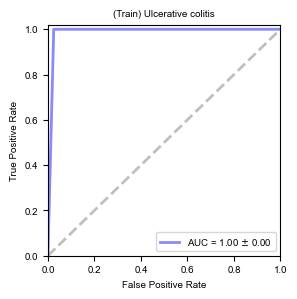

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score

dir1 = 'gene abundance (disease)/'
dir2 ='optimum parameter in randomforest/' 
dir3 = 'fig/Receiver Operating Characteristic (ROC) Curve/'
gene_list=['K11707','K11708','K11709','K11710','K12436','K09802','K07671','K03289','K03283','K03006','K02663']
Disease_list=['Arthritis_High','Arthritis_Moderate','ColorectalCancer_AdvancedAdenoma','ColorectalCancer_Carcinoma','CrohnsDisease','LiverCirrhosis','Obesity','Type2Diabetes','UlcerativeColitis']
control_list=['Arthritis_None','Arthritis_None','ColorectalCancer_Controls','ColorectalCancer_Controls','CrohnsDisease_None','LiverCirrhosis_None','Obesity_None','Type2Diabetes_None','UlcerativeColitis_None']
Disease_list2=['Arthritis high','Arthritis moderate','Colorectal cancer advanced adenoma','Colorectal cancer carcinoma','Crohn\'s disease','Liver cirrhosis','Obesity','Type 2 diabetes','Ulcerative colitis']

for i in range(len(Disease_list)):
    df0=pd.read_csv(dir1+Disease_list[i]+'_Gene_abundance',index_col=0,sep='\t')
    df1=pd.read_csv(dir1+control_list[i]+'_Gene_abundance',index_col=0,sep='\t')
    
    data = pd.concat([
        df0[gene_list].assign(index=1),
        df1[gene_list].assign(index=0)
    ])
    y = data['index'].values
    X = data.drop(columns='index').values

    file_list = ['(Test)','(Train)']
    for k in range(len(file_list)):
        df=pd.read_csv(dir2+file_list[k]+' optimum parameter of '+Disease_list[i]+' in random forest(11_genes).csv',index_col=0)
        roc_auc = df.mean(axis=1)
        max_index_index_roc_auc = roc_auc.idxmax()
        n_estimators = int(max_index_index_roc_auc.split('T')[1])
        random_state = [1,3,5,7,9]
        fpr_list=[]
        tpr_list=[]
        auc_list = []
        for j in range(len(random_state)):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=random_state[j],stratify=y)
            clf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state[j],class_weight='balanced')
            clf.fit(X_train, y_train)
          
            if file_list[k] == '(Test)':
                y_proba = clf.predict_proba(X_test)[:, 1]
                fpr, tpr, _ = roc_curve(y_test, y_proba)
                roc_auc1 = auc(fpr, tpr)
                fpr_list.append(fpr)
                tpr_list.append(tpr)
                auc_list.append(roc_auc1)
            else:
                y_proba = clf.predict_proba(X_train)[:, 1]
                fpr, tpr, _ = roc_curve(y_train, y_proba)
                roc_auc1 = auc(fpr, tpr)
                fpr_list.append(fpr)
                tpr_list.append(tpr)
                auc_list.append(roc_auc1)

        max_size = max([fpr.size for fpr in fpr_list])
        mean_fpr = np.linspace(0, 1, max_size)
        tprs = []
        for fpr, tpr in zip(fpr_list, tpr_list):
            tprs.append(np.interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0

        mean_tpr = np.mean(tprs, axis=0)
        std_tpr = np.std(tprs, axis=0)

        tprs_upper = np.minimum(mean_tpr + 1.96 * std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - 1.96 * std_tpr, 0)

        mean_auc = np.mean(auc_list)
        std_auc = np.std(auc_list)

        # Plot the average ROC curve and confidence interval
        plt.figure(figsize=(3, 3))
        plt.rcParams['pdf.fonttype'] = 42
        plt.rcParams['font.family'] = 'Arial'
        plt.plot(mean_fpr, mean_tpr, color='#8A8AFF', label=r'AUC = %0.2f $\pm$ %0.2f' % (mean_auc, std_auc), lw=2)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='#8A8AFF', alpha=0.2)
        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='grey',alpha=0.5)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.02])
        plt.xlabel('False Positive Rate',fontsize=7)
        plt.ylabel('True Positive Rate',fontsize=7)
        plt.xticks(fontsize=7)
        plt.yticks(fontsize=7)
        plt.title(f'{file_list[k]} {Disease_list2[i]}',fontsize=7)
        plt.legend(loc="lower right",fontsize=7)
        plt.savefig(dir3+file_list[k]+' Receiver Operating Characteristic (ROC) Curve(11 gene) in '+Disease_list2[i]+'.pdf', bbox_inches='tight')